<a href="https://colab.research.google.com/github/ti-lei/data-course-sample/blob/main/%E3%80%8Csample_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Code

## 基礎建設

In [1]:
# test
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [3]:
# windows (!python -m)跟 在 colab(!wget) 有差
!python -m wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!python -m wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz


Saved under All_Beauty.csv

Saved under meta_All_Beauty.json.gz


In [112]:
metadata = getDF('meta_All_Beauty.json.gz')
# 原始資料沒有 header 另外命名給他
ratings = pd.read_csv('All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)
# 輸出metada 到csv
# metadata.to_csv('metada.csv',index=False)

In [113]:
ratings.head()
# 將 metada 取出要用的資訊
maindata = metadata[['rank','price','asin']]
# 直接把資料重複的丟掉
maindata = maindata.drop_duplicates(subset=['asin'])

## 資料整理

In [114]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')
# 把 unixReviewTime drop
ratings.drop(columns=['unixReviewTime'],inplace = True)

## 資料切分

In [115]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
# agg(list)會把所有除了reviewerID的欄位用陣列包住
# to_dict 會把 dataframe 轉成字典(一列一個字典) 並用 陣列包住
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')

# 把 [{'asin': ['B01DKQAXC0'], 'reviewerID': 'A100XQFWKQ30O2'},..] 變成 {A100XQFWKQ30O2:['B01DKQAXC0'],...}
# key: reviwerID value: asin
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }

# users:[user1,user2....]
users = list(ratings_testings_by_user.keys())

# 應該要測試 users 在測試的資料裡 是否有跟 訓練的資料重疊 如果沒有的話根本不知道其消費行為 根本隨便推薦:


# maindata資料整理

In [116]:
# maindata[maindata['asin'].astype(bool)]

# 處理 Rank的部分 將 rank 轉為數字
rankseries = maindata['rank'].str.split(expand=True)
maindata['rank'] = rankseries[0]
maindata['rank'].replace(',','', regex=True, inplace=True)
maindata['rank'] = maindata['rank'].apply(pd.to_numeric,errors='coerce')
#替換字元 ,或是 - 換成空白
maindata['price'] = maindata['price'].str.replace(',|\-', '')
# 如果 price 是空白 或是第一個字元不是$ 或是 字串長度過長('$12.90 -$169.95') 就給0
maindata['price'] = maindata['price'].map(lambda x: 0 if not x or x[0]!='$' or len(x)>6 else float(x[1:]))
# 處理outlier, 有一筆資料的rank過大
maindata = maindata[maindata['rank'] <= 0.8*10**7]


<ipython-input-116-77b80527c6be>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  maindata['price'] = maindata['price'].str.replace(',|\-', '')


In [ ]:
# 合併兩個表

In [117]:
#將 index 設為asin後就可以把資料合進去
maindata = maindata.set_index('asin')
# 紀錄產品平均評分
maindata['overall_mean'] = ratings_trainings.groupby(by=['asin']).mean()['overall']

# 紀錄產品評分次數
maindata['reviews_count'] = ratings_trainings.groupby(by=['asin']).size()

In [137]:
# 最近 3個月內的rating
buy_last_two_month = ratings_trainings[
    (ratings['DATE'] < '2018-09-01') & (ratings['DATE'] > '2018-06-01')
]
maindata['buy_last_three_month'] = buy_last_three_month.groupby(by=['asin']).size().sort_values(ascending=False)

maindata.sort_values(['rank','reviews_count'],ascending=[True, False]).head(20)

# 測試資料是最後一個月的資料，所以前面一小段時間有購買行為的商品都可以視為潛在的推薦商品
# 隨著時間接近 商品的銷售有成長的狀態 取近六個月的 加權平均



<ipython-input-137-197d34fa0607>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buy_last_three_month = ratings_trainings[


,rank,price,overall_mean,reviews_count,buy_last_three_month
asin,,,,,
B00BXPVIT8,35.0,21.44,4.846154,13.0,NaN
B006IB5T4W,65.0,11.29,4.643369,2790.0,57.0
B00HYEPVG8,245.0,9.59,4.588235,34.0,9.0
B001QY8QXM,280.0,9.30,4.556118,4544.0,16.0
B00005JS5C,457.0,18.49,4.088039,2249.0,NaN
B007EITOSK,575.0,3.90,3.904934,831.0,18.0
B00BXR0SFG,853.0,11.94,4.500000,2.0,NaN
B002OITLG0,872.0,8.40,4.313025,476.0,7.0
B01DJI7796,1017.0,6.95,4.583333,120.0,11.0


In [209]:
buy_last_two_month = ratings_trainings[
    (ratings['DATE'] < '2018-02-01') & (ratings['DATE'] > '2018-01-01')
]
buy_last_two_month = buy_last_two_month.groupby(by=['asin']).size()
buy_last_three_month = ratings_trainings[
    (ratings['DATE'] < '2018-03-01') & (ratings['DATE'] > '2018-02-01')
]
buy_last_three_month = buy_last_three_month.groupby(by=['asin']).size()

<ipython-input-209-a031d9c76c1d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buy_last_two_month = ratings_trainings[
<ipython-input-209-a031d9c76c1d>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buy_last_three_month = ratings_trainings[


In [212]:
sum(buy_last_two_month.index.duplicated())

0

In [249]:
from datetime import datetime
from dateutil.relativedelta import *
# 開始時間的陣列
start_date = []
# 結束時間的陣列
end_date = []
# 紀錄每個時間間格購買數量
buy_in_every_month = pd.DataFrame()
#起始時間
basic_date = datetime(2018, 1, 1)
for i in range(6):
    start_date = basic_date+relativedelta(months=+i)
    end_date = basic_date+relativedelta(months=+i+1)

    buy_last_one_month = ratings_trainings[
        (ratings['DATE'] < end_date.strftime("%Y-%m-%d")) & (ratings['DATE'] > start_date.strftime("%Y-%m-%d"))
    ]
    buy_last_one_month = buy_last_one_month.groupby(by=['asin']).size()
    #數據加權 越接近資料時間的終點加權越重
    weight = i + 1
    buy_last_one_month = weight * buy_last_one_month
    #  第一次不能用 inner join 不然dataframe是空的
    if i== 0:
        buy_in_every_month = pd.concat([buy_in_every_month, buy_last_one_month])
    # axis = 1 是以欄為單位 往右邊去 合併
    else:
        buy_in_every_month = pd.concat([buy_in_every_month, buy_last_one_month], axis=1)
#第一層濾網先把前20名銷量篩出來
top20 = buy_in_every_month.sum(axis=1).sort_values(ascending = False)[:20].index
#第二層將單月完全沒有銷量的產品篩掉
top10 = buy_in_every_month.loc[top20,:].dropna().index[:10]
buy_in_every_month.loc[top10,:]

<ipython-input-249-83ebcd8e075a>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buy_last_one_month = ratings_trainings[


,0,0,0,0,0,0
B01DKQAXC0,210.0,434.0,579.0,524.0,625.0,642.0
B006IB5T4W,73.0,168.0,273.0,312.0,310.0,342.0
B0195R1FT8,72.0,150.0,252.0,288.0,260.0,108.0
B00W259T7G,60.0,176.0,150.0,152.0,230.0,348.0
B001QY8QXM,52.0,86.0,165.0,228.0,210.0,96.0
B012Z7IHHI,30.0,54.0,57.0,100.0,130.0,168.0
B007EITOSK,19.0,40.0,105.0,112.0,125.0,108.0
B00GW58YC8,18.0,32.0,105.0,104.0,140.0,90.0
B01BZV6VVY,53.0,72.0,144.0,128.0,60.0,30.0
B005IHT94S,7.0,20.0,36.0,84.0,140.0,168.0


In [ ]:
# 畫圖

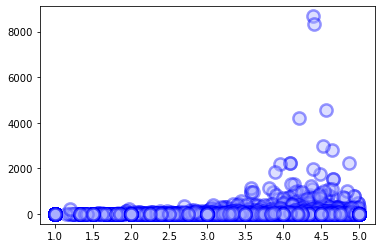

In [96]:
import matplotlib.pyplot as plt
# 製作figure  
fig = plt.figure()
#圖表的設定
ax = fig.add_subplot(1, 1, 1)

#散佈圖 rank 對price
x = maindata['overall_mean']
y = maindata['reviews_count']
ax.scatter(x, y, s=150, alpha=0.4, linewidths=2.5, c='#AAAFFF', edgecolors='blue')
plt.show() 


In [86]:
# 處理outlier
maindata = maindata[maindata['rank'] <= 0.8*10**7]



In [ ]:
# 將 metada 取出要用的資訊
maindata = metadata[['rank','price','asin']]
# 計算 asin 總共有多少種 確定不是唯一
maindata['asin'].value_counts()
print(len(maindata))
# 直接把資料重複的丟掉
maindata = maindata.drop_duplicates(subset=['asin'])
# 處理 Rank的部分 將 rank 轉為數字
rankseries = maindata['rank'].str.split(expand=True)
maindata['rank'] = rankseries[0]
maindata['rank'].replace(',','', regex=True, inplace=True)
maindata['rank'] = maindata['rank'].apply(pd.to_numeric,errors='coerce')

# 將產品DATA 跟　評價DATA 合併
print(len(maindata))

32892


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


32488


In [ ]:
# 把also_view 空白的資料拿掉後取出商品ID和also_view的欄位
# alsoview = maindata[maindata['also_view'].astype(bool)][['also_view','asin']].to_dict('records')
# 把review ID 進行 Group 去檢查 這些人同時買了些什麼?
# ratings_trainings_reviewrID_asin = ratings_trainings[['reviewerID','asin']].groupby('reviewerID').agg(list).reset_index().to_dict('records')


# 產生Asin 對應會一起買的商品

In [ ]:
# 把also_view 空白的資料拿掉後取出商品ID和also_view的欄位
alsobuy = maindata[maindata['also_buy'].astype(bool)][['also_buy','asin']].to_dict('records')
# 建立 商品 對應到會一起買的商品ID
alsobuy_by_asin = { item['asin']: item['also_buy'] for item in alsobuy }
alsobuy_by_asin

# user 傾向買銷售排名 較前面的商品(rank)
# user 的價格屬性偏向 某個價位的商品(price)
# user 之前買過的產品 發現不滿意想要找其他品牌的商品 (rating no good, also view)
# user 之前買過的商品 發現還需要其他的商品 藉由查找 alsobuy 來尋找可能會要再購買的產品 

# 銷量排名 rating (評價分數)
# rank排名
# 銷售時間最接近testing data (大家最近都買這些)
# 
# 


# user 之前買過的商品 獲得 比較好的評價 預期會再買一次
# users 是待推薦的測試資料集的users
def buy_it_again(users):
  for user in users:
    # 藉由從testingdata 的 user 拿到 trainingdata使用者購買的商品, 這裡可能會拿到一個陣列
    asin_ID_list = ratings_trainings_by_user[user]
    # 查找asinID 對應到的 alsobuy 的商品, asin_ID_also_buy 也可能是一個陣列
    for item in asin_ID_list:
      asin_ID_also_buy = item[alsobuy_by_asin]


In [ ]:
def buy_it_again(users):
  result = {}
  
  for user in users:
    try:
    # 藉由從testingdata 的 user 拿到 trainingdata使用者購買的商品, 這裡可能會拿到一個陣列
      if user not in ratings_testings_by_user:
        print(user,'not exist in trainings')
        asin_ID_list = ratings_testings_by_user[user]

      # 查找asinID 對應到的 alsobuy 的商品, asin_ID_also_buy 也可能是一個陣列
      for item in asin_ID_list:
        asin_ID_also_buy = item[alsobuy_by_asin]
        result[user] = asin_ID_also_buy
        print(result)
    except Exception as e:
      pass
  return result

In [ ]:
buy_it_again(users)
# ratings_testings_by_user['A100XQFWKQ30O2']

{}

## 產生推薦

In [ ]:
def recommender(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    ratings_testings_by_user = training_data.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
    return recommendations


ratings_by_user = recommender(ratings_trainings, users)
ratings_by_user

{}

## 結果評估

In [ ]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 是測試資料裡 key:user value:商品ID 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)

NameError: ignored